We got employee data from a few companies. We have data about all employees who joined from 2011/01/24 to 2015/12/13. For each employee, we also know if they are still at the company as of 2015/12/13 or they have quit. Beside that, we have general info about the employee, such as average salary during her tenure, department, and years of experience. As said above, the goal is to predict employee retention and understand its main drivers.

All data challenges should involve:
1. Loading and inspecting the data
2. Model formulation, validation, comparison and selection
3. Recommendations

Hints:
1. What are the main factors that drive employee churn? Do they make sense? Explain your findings?
2. What might you be able to do for the company to address employee Churn, what would be follow-up actions?
3. If you could add to this data set just one variable that could help explain employee churn, what would that be?
4. Your output should be in the form a a jupyter notebook and pdf output of a jupyter notebook in which you specify your results and how you got them.

Columns:
1. employee_id : id of the employee. Unique by employee per company 
2. company_id : company id. 
3. dept : employee department 
4. seniority : number of yrs of work experience when hired 
5. salary: average yearly salary of the employee during her tenure within the company 
6. join_date: when the employee joined the company, it can only be between 2011/01/24 and 2015/12/13 
7. quit_date: when the employee left her job (if she is still employed as of 2015/12/13, this field is NA)

My hypotheses/ questions:
1. Lower seniority and lower salary employees are more likely to leave (less motivation to stay)
2. Is there significant variation between companies?

First thoughts on modeling algorithm:
1. Generalized Linear Mixed‐effects Model (GLMM), y = left_company, x = seniority, salary, groups = dept, company_id

Other people used:
1. Random Forest
2. Survival Analysis

Survival Analysis appears to be the best method for churn analysis. Could also do binary classifier of some sort, but that seems like a supplementary analysis (including RF, GLM, or GLMM).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

%matplotlib inline
pd.options.mode.chained_assignment = None  

In [3]:
employee_retention =  pd.read_csv("./data/employee_retention.csv")

In [4]:
employee_retention = employee_retention.drop(columns='Unnamed: 0')

In [5]:
#employee_retention.head()
#employee_retention.dtypes
#employee_retention.isnull().sum()
#_ = [print(employee_retention[col].describe()) for col in employee_retention]
#_ = [print(employee_retention[col].nunique()) for col in employee_retention]

We have about 34702 rows. All are unique employees (according to ID), 12 companies, 7 departments, 32 seniority levels (mostly up to about 30, though range up to 99), Salaries ranging from 5000 to 408000 (240 missing data), join dates, and quit dates (lots of null, but that's ok).

Check join dates and quit dates.
Remove rows with missing salaries? Or impute?
What to do about seniority levels?

In [6]:
plt.figure()
plt.clf()
#_ = employee_retention.hist(column=['seniority','salary'] ,figsize=(6,6))

<Figure size 432x288 with 0 Axes>

In [7]:
#employee_retention.seniority.sort_values().tail()
# get rid of 98 and 99, could set this threshold to another more general (and still possible) value, like....50?
employee_retention.loc[employee_retention.seniority > 29,'seniority'] = np.nan

In [8]:
# remove rows with NA for salary
employee_retention = employee_retention.loc[employee_retention.salary.notnull()]
employee_retention = employee_retention.loc[employee_retention.seniority.notnull()]

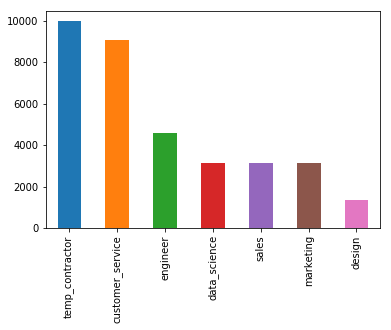

In [9]:
_ = pd.value_counts(employee_retention['dept']).plot.bar()

In [10]:
# clean up join_date field
employee_retention.join_date = employee_retention.join_date.str.split('.').apply(lambda x: '-'.join(x[-1:] + x[:-1]))
employee_retention['join_date'] =  pd.to_datetime(employee_retention['join_date'], format='%Y-%m-%d')
employee_retention['quit_date'] =  pd.to_datetime(employee_retention['quit_date'], format='%Y-%m-%d')
employee_retention['left_company'] = 1
employee_retention.loc[employee_retention.quit_date.isnull(),'left_company'] = 0
#_ = employee_retention.left_company.plot.hist()

In [11]:
# calculate days worked for those who left
employee_retention['days_worked'] = (employee_retention.quit_date - employee_retention.join_date).astype('timedelta64[D]')

In [12]:
# calculate days worked for those who haven't left yet
employee_retention.loc[employee_retention.days_worked.isnull(),'days_worked'] = (datetime.strptime('2015-12-13', '%Y-%m-%d') - employee_retention.join_date).astype('timedelta64[D]')

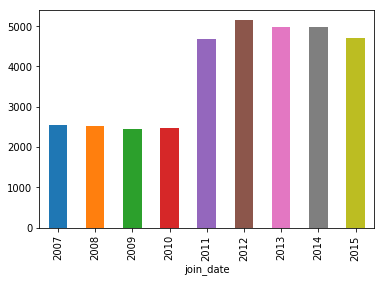

In [13]:
_ = employee_retention.join_date.groupby(employee_retention["join_date"].dt.year).count().plot(kind="bar")

In [14]:
# there are 10000 dates before 2011
# drop these?
# I don't need start date to know that someone left the company
# it is only useful if I want to know how long they were there, and anyways it's hard to really use that information
# because I don't know how long employees were at the company before 2011
# so I can just leave those rows in, until I decide how to use the time at company
sum(employee_retention["join_date"].dt.year < 2011)

10000

In [15]:
# apparently all 10000 of these rows are temporary contractors on 90 days contracts, we can throw them out
employee_retention.loc[employee_retention["join_date"].dt.year < 2011].dept.unique()

array(['temp_contractor'], dtype=object)

In [16]:
employee_retention = employee_retention.loc[employee_retention["join_date"].dt.year >= 2011]

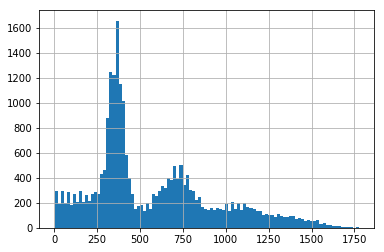

In [17]:
# as Mike noted, there is a spike around 1 and 2 years (less so)
employee_retention['days_worked'].hist(bins=100)

In [18]:
# select data for which we have at least two years run time
# coyld use this in a logistic regression (preferably mixed-effects)
employee_retention_select = employee_retention.loc[employee_retention.join_date < datetime.strptime('2013-12-13', '%Y-%m-%d')]
employee_retention_select['worked_2_years'] = 0
employee_retention_select['worked_2_years'] = (employee_retention_select['days_worked'] > 730).astype(int)

## Survival Analysis

In [19]:
# Survival analysis
kmf = KaplanMeierFitter()

kmf.fit(employee_retention.days_worked, event_observed=employee_retention.left_company)

<lifelines.KaplanMeierFitter: fitted with 24461 observations, 11084 censored>

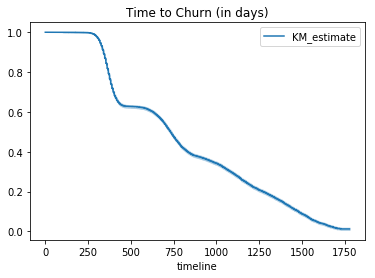

In [20]:
kmf.plot(title='Time to Churn (in days)')

In [21]:
print(kmf.median_)
print(kmf.survival_function_.KM_estimate[1*365])
print(kmf.survival_function_.KM_estimate[2*365])
print(kmf.survival_function_.KM_estimate[3*365])

732.0
0.816279005742281
0.5042462153206106
0.2946060768223561


In [22]:
# Then can create separate classes for high medium and low salary, and do separate model fits.
# can't just throw those variables into the model?
# read this https://lifelines.readthedocs.io/en/latest/Survival%20Analysis%20intro.html
# why months employed vs days employed
# Che used a Cox Proportional Hazards to include covariate effects

In [23]:
coxph = CoxPHFitter()
coxph.fit(employee_retention[['left_company','days_worked','salary','seniority']], duration_col='days_worked', event_col='left_company')

coxph.print_summary()  # access the results using cph.summary

n=24461, number of events=13377

             coef  exp(coef)  se(coef)        z      p  lower 0.95  upper 0.95     
salary    -0.0000     1.0000    0.0000 -12.0957 0.0000     -0.0000     -0.0000  ***
seniority  0.0095     1.0095    0.0013   7.2538 0.0000      0.0069      0.0120  ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1 

Concordance = 0.530
Likelihood ratio test = 149.656 on 2 df, p=0.00000


In [24]:
# add dummy variables for company and dept? Or is there some way to use these as groups?
# what's the best way to include and interpret variables in a Cox Proportional Hazards test. 
# https://www.stat.ubc.ca/~rollin/teach/643w04/lec/node69.html